In [101]:
import jax.numpy as jnp
from jax import random, grad, vmap
from functools import partial
import matplotlib.pyplot as plt
import jaxgp.regression as gpr
from jaxgp.kernels import RBF, Linear, Constant
import timeit
import time

# Full GPR

## Benchmark memory of fitmatrix and fitvector

## Benchmarking with a constant function

In [111]:
data_sizes = [100, 200, 500, 1000, 2000, 3000, 4000, 5000]

kernel_1 = RBF()
kernel_2 = Linear()

### Timing of the training

In [103]:
# for elem in data_sizes:
#     data_split = (elem, )

#     X_data = jnp.linspace(0.0, 1.0, data_split[0]).reshape(-1,1)
#     Y_data =jnp.ones(data_split[0]).reshape(-1)

#     def test_RBF():
#         model = gpr.ExactGPR(kernel=kernel_1, data_split=data_split, noise=0.1)
#         model.train()
#         model(X_data=X_data, Y_data=Y_data)

#     print(f"N={elem}: {timeit.repeat(test_RBF, repeat=1, number=1)}")

### Timing of eval with constant X_grid for different training sizes

In [104]:
# X = jnp.linspace(0.2, 0.8, 5000).reshape(-1,1)

# for elem in data_sizes:
#     data_split = (elem, )

#     X_data = jnp.linspace(0.0, 1.0, data_split[0]).reshape(-1,1)
#     Y_data =jnp.ones(data_split[0]).reshape(-1)

#     model = gpr.ExactGPR(kernel=kernel_1, data_split=data_split, noise=0.1)
#     model.train_regression()
#     model(X_data=X_data, Y_data=Y_data)
#     model.eval()

#     def test_RBF():
#         model(X)


#     print(f"N={elem}: {timeit.repeat(test_RBF, repeat=1, number=1)}")

# Sparse GPR

### Timing of the training

In [114]:
# for elem in data_sizes:
#     data_split = (elem, )

#     X_data = jnp.linspace(0.0, 1.0, data_split[0]).reshape(-1,1)
#     Y_data =jnp.ones(data_split[0]).reshape(-1)
#     X_ref = jnp.linspace(0.0,1.0,data_split[0]//20).reshape(-1,1)

#     def test_RBF():
#         model = gpr.SparseGPR(kernel=kernel_1, data_split=data_split, X_ref=X_ref, noise=0.1)
#         model.train()
#         model(X_data=X_data, Y_data=Y_data)

#     print(f"N={elem}: {timeit.repeat(test_RBF, repeat=1, number=1)}")

OptStep(params=DeviceArray([1.0003844], dtype=float32), state=ScipyMinimizeInfo(fun_val=DeviceArray(-0.02197648, dtype=float32, weak_type=True), success=True, status=0, iter_num=2))
N=100: [1.2688470120046986]
OptStep(params=DeviceArray([1.0026379], dtype=float32), state=ScipyMinimizeInfo(fun_val=DeviceArray(-0.04973743, dtype=float32, weak_type=True), success=False, status=2, iter_num=2))
N=200: [1.031576690998918]
OptStep(params=DeviceArray([1.], dtype=float32), state=ScipyMinimizeInfo(fun_val=DeviceArray(-0.11379737, dtype=float32, weak_type=True), success=True, status=0, iter_num=1))
N=500: [0.9684578860033071]
OptStep(params=DeviceArray([1.0043498], dtype=float32), state=ScipyMinimizeInfo(fun_val=DeviceArray(-0.22904204, dtype=float32, weak_type=True), success=False, status=2, iter_num=4))
N=1000: [1.984935004998988]
OptStep(params=DeviceArray([1.0044796], dtype=float32), state=ScipyMinimizeInfo(fun_val=DeviceArray(-0.4614336, dtype=float32, weak_type=True), success=True, status=0

# Try a weird function

In [106]:
key = random.PRNGKey(int(time.time()))

def f(x, noise=0):
    return jnp.sin(2*x**2 + 1/(x+0.5/jnp.pi))*x + noise*random.normal(key,x.shape)

gradient = vmap(grad(f), in_axes=(0,None))

def df(x, noise=0):
    return gradient(x, noise) + noise*random.normal(key,x.shape)

# def f(x, noise=0.0):
#     temp = jnp.where(x<0, -x, x)
#     return temp + noise*random.normal(key,x.shape)

# def df(x, noise=0.0):
#     temp = jnp.where(x<0, -1.0, 1.0)
#     return temp + noise*random.normal(key,x.shape)

In [107]:
bounds = jnp.array([0.0, jnp.pi])
# bounds = jnp.array([-1.0, 1.0])

noise = 0.5

length_scale = 1.0

num_datapoints = 5
datagrid = jnp.linspace(*bounds,num_datapoints)
data_values = f(datagrid,noise)
num_derivpoints = (50,)
# derivative_grid = jnp.linspace(*bounds,num_derivpoints[0])
derivative_grid = random.uniform(key, num_derivpoints, minval=bounds[0], maxval=bounds[1])
derivative_values = df(derivative_grid,noise)
data_split = (num_datapoints, ) + num_derivpoints

X_data = jnp.concatenate((datagrid,derivative_grid)).reshape(-1,1)
Y_data = jnp.concatenate((data_values,derivative_values)).reshape(-1)

num_referencepoints = 30
# referencegrid = jnp.linspace(*bounds,num_referencepoints).reshape(-1,1)
referencegrid = random.uniform(key, (num_referencepoints,), minval=bounds[0], maxval=bounds[1]).reshape(-1,1)

num_gridpoints = 101
grid = jnp.linspace(*bounds,num_gridpoints)

kernel = Constant() * RBF()# + Linear()
kernel_params = (length_scale, length_scale)#, 1.0, 1.0)

In [108]:
model = gpr.ExactGPR(kernel,data_split,kernel_params,noise=noise)
model.train()
model(X_data,Y_data)
model.eval()
means_full, stds_full = model(grid.reshape(-1,1))
means_full = means_full.reshape(-1)
stds_full = stds_full.reshape(-1)

model = gpr.SparseGPR(kernel,data_split,referencegrid,kernel_params,noise=noise)
model.train()
model(X_data,Y_data)
model.eval()
(means_ppa, stds_ppa) = model(grid.reshape(-1,1))
means_ppa = means_ppa.reshape(-1)
stds_ppa = stds_ppa.reshape(-1)

OptStep(params=DeviceArray([7.45873   , 0.20975937], dtype=float32), state=ScipyMinimizeInfo(fun_val=DeviceArray(0.00475178, dtype=float32, weak_type=True), success=True, status=0, iter_num=20))
OptStep(params=DeviceArray([1.0680418 , 0.20990327], dtype=float32), state=ScipyMinimizeInfo(fun_val=DeviceArray(0.00652223, dtype=float32, weak_type=True), success=True, status=0, iter_num=4))


In [109]:
print(stds_full)

[0.42766246 0.4294644  0.42963424 0.42944828 0.42993602 0.43109733
 0.43218988 0.43239173 0.4314119  0.4298423  0.42898446 0.43025365
 0.43426022 0.43996552 0.4443649  0.44298548 0.43120405 0.4059905
 0.36760673 0.32100472 0.2765319  0.24796613 0.24380152 0.25775978
 0.27518365 0.28522396 0.28456452 0.27581018 0.26444745 0.25541356
 0.2506857  0.24937074 0.24958767 0.2499752  0.24993227 0.24928945
 0.24817084 0.24691491 0.24593772 0.24546807 0.24547875 0.24571174
 0.2459164  0.24588925 0.2455681  0.24504909 0.24452996 0.24420018
 0.24407715 0.24408397 0.24409765 0.24406444 0.24399213 0.24397162
 0.24410644 0.24442366 0.2447658  0.24482618 0.24446464 0.24395011
 0.2438905  0.24474534 0.24631163 0.24782859 0.24846655 0.2479517
 0.24672751 0.24565157 0.24539132 0.24599878 0.24695352 0.24760626
 0.24763708 0.24720152 0.24667628 0.24640067 0.24650612 0.24696511
 0.24765536 0.24826689 0.2483917  0.24787764 0.24726902 0.24773045
 0.25009343 0.25395507 0.25779772 0.2601948  0.26088113 0.260655

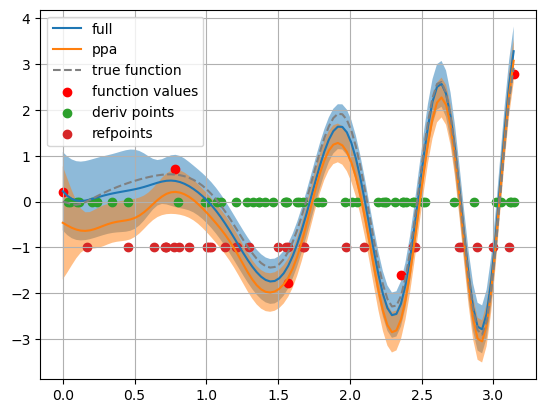

In [110]:
plt.plot(grid,means_full,label="full")
plt.fill_between(grid,means_full-2*stds_full,means_full+2*stds_full,alpha=0.5)
plt.plot(grid,means_ppa,label="ppa")
plt.fill_between(grid,means_ppa-2*stds_ppa,means_ppa+2*stds_ppa,alpha=0.5)
plt.plot(grid,f(grid,0.0),color="grey",ls="--",label="true function")
plt.scatter(datagrid,data_values,color="r",label="function values")
plt.scatter(derivative_grid,jnp.zeros_like(derivative_grid),label="deriv points")
plt.scatter(referencegrid.reshape(-1), -jnp.ones_like(referencegrid.reshape(-1)), label="refpoints")
plt.grid()
plt.legend()